In [14]:
!wget https://data.vision.ee.ethz.ch/sagea/lld/data/LLD-logo.hdf5

--2019-11-10 05:18:12--  https://data.vision.ee.ethz.ch/sagea/lld/data/LLD-logo.hdf5
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.162
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.162|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13502317373 (13G)
Saving to: ‘LLD-logo.hdf5’

LLD-logo.hdf5       100%[===================>]  12.57G  19.5MB/s    in 11m 50s 

2019-11-10 05:30:03 (18.1 MB/s) - ‘LLD-logo.hdf5’ saved [13502317373/13502317373]



In [2]:
import torch 
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm_notebook, trange, tqdm
import torchvision.transforms.functional as TF
import torch.optim as optim
import h5py
import matplotlib.pyplot as plt
from PIL import Image
import cv2
%matplotlib inline

In [3]:
img_size = (32, 32)
class HDF5LogoDataLoader(Dataset):
    def __init__(self, hdf5_path='LLD-logo.hdf5', resize_shape=img_size):
        self.hdf5_file = h5py.File(hdf5_path, 'r')
        self.images = self.hdf5_file['data']
        self.shapes = self.hdf5_file['shapes']
        self.resize_shape = resize_shape

    def __len__(self):
        return len(self.images)

    def transform_image(self, image):
        image = image.transpose(1, 2, 0)
        img_resized = cv2.resize(image, dsize=self.resize_shape)
        img_resized_tensor = TF.to_tensor(img_resized)
        # print(img_resized_tensor.max())
        normalize_img = TF.normalize(img_resized_tensor, mean=[127.5,127.5,127.5], std=[127.5,127.5,127.5])
        # print(normalize_img.max())
        # print(normalize_img.min())
        return normalize_img

    def __getitem__(self, idx):
        img_shape = self.shapes[idx]
        # print(self.images[idx].shape)
        img_without_padding = self.images[idx][:, :img_shape[1], :img_shape[2]]
        return self.transform_image(img_without_padding)

In [4]:
hdf5_dataset = HDF5LogoDataLoader()

In [5]:
def undo_normalize(t, val):
 return t*val + val

In [6]:
img_size = (32, 32)

torch.Size([10, 3, 32, 32])


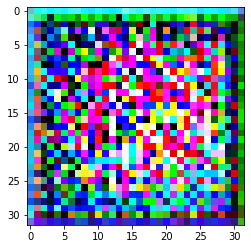

In [7]:
class Generator(nn.Module):
    
    def __init__(self):
        super(Generator, self).__init__()
        
        self.conv1_1 = nn.ConvTranspose2d(100, 1024, 4, 1)
        self.bn1_1 = nn.BatchNorm2d(1024)
        self.conv1_2 = nn.ConvTranspose2d(1024, 1024, 3)
        self.bn1_2 = nn.BatchNorm2d(1024)
        
        self.conv2_1 = nn.ConvTranspose2d(1024, 512, 4, 2, 1)
        self.bn2_1 = nn.BatchNorm2d(512)
        self.conv2_2 = nn.ConvTranspose2d(512, 512, 3)
        self.bn2_2 = nn.BatchNorm2d(512)
        
        self.conv3_1 = nn.ConvTranspose2d(512, 256, 4, 2, 1)
        self.bn3_1 = nn.BatchNorm2d(256)
        self.conv3_2 = nn.ConvTranspose2d(256, 256, 3)
        self.bn3_2 = nn.BatchNorm2d(256)
        
        self.conv4 = nn.ConvTranspose2d(256, 3, 3)
  
    def forward(self, latent_vector):
        x = F.relu(self.bn1_1(self.conv1_1(latent_vector)))
        x = F.relu(self.bn1_2(self.conv1_2(x)))
        
        x = F.relu(self.bn2_1(self.conv2_1(x)))
        x = F.relu(self.bn2_2(self.conv2_2(x)))
        
        x = F.relu(self.bn3_1(self.conv3_1(x)))
        x = F.relu(self.bn3_2(self.conv3_2(x)))

        x = torch.tanh(self.conv4(x))
        return x

gen = Generator()
test = torch.randn(10, 100, 1, 1)
gen(test).shape

output = gen(test)
print(output.shape)
plt.imshow(undo_normalize(output[0], 127.5).detach().numpy().transpose(1, 2, 0).astype(np.uint8))

In [8]:
class Discriminator(nn.Module):

    def __init__  (self):

        super(Discriminator, self).__init__()
        
        self.conv1_1 = nn.Conv2d(3, 256, 4, 2, 2)
        self.bn1_1 = nn.BatchNorm2d(256)
        self.conv1_2 = nn.Conv2d(256, 256, 3)
        self.bn1_2 = nn.BatchNorm2d(256)

        self.conv2_1 = nn.Conv2d(256, 512, 4, 2, 2)
        self.bn2_1 = nn.BatchNorm2d(512)
        self.conv2_2 = nn.Conv2d(512, 512, 3)
        self.bn2_2 = nn.BatchNorm2d(512)

        self.conv3_1 = nn.Conv2d(512, 1024, 4, 2, 2)
        self.bn3_1 = nn.BatchNorm2d(1024)
        self.conv3_2 = nn.Conv2d(1024, 1024, 3)
        self.bn3_2 = nn.BatchNorm2d(1024)
        
        self.conv4 = nn.Conv2d(1024, 1, 2)
        
        #self.fc2 = nn.Linear(512, 1)

    def forward(self, img):
        x = F.leaky_relu(self.bn1_1(self.conv1_1(img)),negative_slope=0.2)
        x = F.leaky_relu(self.bn1_2(self.conv1_2(x)),negative_slope=0.2)

        x = F.leaky_relu(self.bn2_1(self.conv2_1(x)),negative_slope=0.2)
        x = F.leaky_relu(self.bn2_2(self.conv2_2(x)),negative_slope=0.2)

        x = F.leaky_relu(self.bn3_1(self.conv3_1(x)),negative_slope=0.2)
        x = F.leaky_relu(self.bn3_2(self.conv3_2(x)),negative_slope=0.2)
        
        x = self.conv4(x)
        return x.view(-1, 1)

gen = Discriminator()
test = torch.randn(10,3,img_size[0],img_size[1])
gen(test).shape

torch.Size([10, 1])

In [9]:
LATENT_SIZE = 100
BATCH_SIZE = 64
generator_model = Generator().cuda()
discriminator_model = Discriminator().cuda()
hdf5_dataloader = DataLoader(hdf5_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
bce_loss = nn.BCELoss()

In [10]:
%%time
NUM_EPOCHS = 25
optimizer_G = torch.optim.Adam(generator_model.parameters(), lr = 1e-4, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator_model.parameters(), lr = 1e-4, betas=(0.5, 0.999))
#x = next(iter(hdf5_dataloader))

disp_img = 100

for epoch in range(NUM_EPOCHS):
    # print("Epoch : ", epoch)
    for iterate, x in enumerate(tqdm(hdf5_dataloader)):
        
        for i in range(2):
        #   dataloader_iter = iter(hdf5_dataloader)
            current_batch_size = BATCH_SIZE
            #real_images = x.cuda()
            #     print(real_images.shape)
            batch_ones = torch.ones((current_batch_size, 1)).cuda()
            batch_zeros = torch.zeros((current_batch_size, 1)).cuda()
            # Generator Training
            latent_vals = torch.randn((current_batch_size, LATENT_SIZE, 1, 1)).cuda()
            # print(latent_vals.shape)
            generated_fakes = generator_model(latent_vals)
            discriminator_results_for_fakes = discriminator_model(generated_fakes)
            #generator_loss = bce_loss(discriminator_results_for_fakes, batch_ones)
            generator_loss = -torch.mean( discriminator_results_for_fakes )

            optimizer_G.zero_grad()
            generator_loss.backward()
            optimizer_G.step()
        
        if iterate%disp_img==0:
            c = 0
            fig, ax = plt.subplots(3,3)
            for pi in range(3):
                for pj in range(3):
                    ax[pi][pj].axis('off')
                    ax[pi,pj].imshow(undo_normalize(generated_fakes[c].cpu().detach().numpy().transpose(1,2,0),127.5).astype(np.uint8))
                    c+=1
                    
            plt.savefig("Gen_2X/Gen_images_{}_{}.png".format(epoch, iterate))
            plt.close()
        
        # Discriminator Training
        #for i in range(2):
          #x = next(dataloader_iter)  
        current_batch_size = x.shape[0]
        real_images = x.cuda()
        discriminator_results_for_true_imgs = discriminator_model(real_images)
        discriminator_results_for_fakes = discriminator_model(generated_fakes.detach())
          # We detach the generated_fakes because we are only training discriminator in this 
          # phase. detach() prevents the gradients from being propagated
          #import pdb;pdb.set_trace()
          
          #fake_loss = bce_loss(discriminator_results_for_fakes, batch_zeros)
          #real_loss = bce_loss(discriminator_results_for_true_imgs, batch_ones)
        real_loss = torch.mean( discriminator_results_for_true_imgs)
        fake_loss = torch.mean( discriminator_results_for_fakes )
          #total_loss = fake_loss + real_loss
        total_loss = - (real_loss - fake_loss) 
        optimizer_D.zero_grad()
        total_loss.backward()
        optimizer_D.step()
          
        for p in discriminator_model.parameters():
            p.data.clamp_(-0.01, 0.01)

100%|██████████| 1921/1921 [16:27<00:00,  1.95it/s]

CPU times: user 7h 44min 11s, sys: 1h 11min 10s, total: 8h 55min 22s
Wall time: 8h 54min 32s


In [10]:
import matplotlib.pyplot as plt

In [ ]:
test_latent = torch.randn((1, LATENT_SIZE)).cuda()

test_gen_image = generator_model(test_latent)
print(test_gen_image.shape)

numpy_img = test_gen_image.squeeze().cpu().detach().numpy().transpose(1,2,0)

numpy_img = undo_normalize(numpy_img, 127.5)
print(numpy_img.max())
plt.imshow(numpy_img.astype(np.uint8))

RuntimeError: Expected 4-dimensional input for 4-dimensional weight 100 1024, but got 2-dimensional input of size [1, 100] instead